In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import tensorflow as tf

In [ ]:
# Keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
# Mounting my GoogleDrive, so that I can access the local data folders through the Colab environment
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Image-Based Deep Learning: *Finding Pneumonia in Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images***

Project by Jonny Hofmeister

Data sourced from [Mendelay](https://data.mendeley.com/datasets/rscbjbr9sj/3).

<img src="images/jZqpV51.png">

##### This project will follow the CRISP-DM process for data science and mining.

## **Business Understanding**

Using the extensive medical databases available to us, we can mine this data for insights that can help to improve research, diagnostics, and the general well-being of patients. 

The data supplied for this project comes from the Medelay website, and more specifically the University of California San Diego, Guangzhou Women and Children's Medical Center and lab contributors Daniel Kermany, Kang Zhang, and Michael Goldbaum. The dataset contains 5840 labeled OCT and X-Ray images. The goal of this data mining and model construction is to be able to accurately classify a patient as having pneumonia or not, based on image information from a chest X-Ray.  

Doctors currently can diagnose treatable bacterial and viral infections like pneumonia with a high degree of reliability. But as we have seen during the COVID-19 epidemic, doctors and mecdical staff are being stretched thin and worked to the limit. Using the abundance of technology and data around us, we should be finding ways to streamline the medical process so that medical personel can spend their time and effort where it is needed most. A model that can successfully classify pneumonia could easily be deployed into medical clinics to help aid and confirm doctors on-hand diagnoses. Further in the future, with more extensive training data and deeper knowledge of real world performance, patients may even be able to be diagnosed with pneumoia with only an X-ray and no doctor examination, and possibly even with a higher degree of accuracy than before. 

## **Data Understanding**

Below, the dataset is imported and we count the total number of labeled images we have access to.

In [ ]:
# From Tensorflow Docs to load into data directory
# This could probably be done by directly adding the path into tf.keras.utils.image_dataset_from_directory(
import pathlib
path = "gdrive/MyDrive/xray_cnn/data_folder"
data_dir = pathlib.Path(path)

# Make sure it loaded by checking the number of images
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

5840


There are a total of 5840 images, all in the .jpeg format. The intial data directory was split into training and validation folders, but I have gone ahead and combined all training and testing into one folder. This way, I can perform my own train/test split on the images with the ratio I decide, and to properly shuffle them before modeling - an important step in deep learning. 

Let's take a peek at an example image from each of the classes - NORMAL and PNEUMONIA.

First, NORMAL:

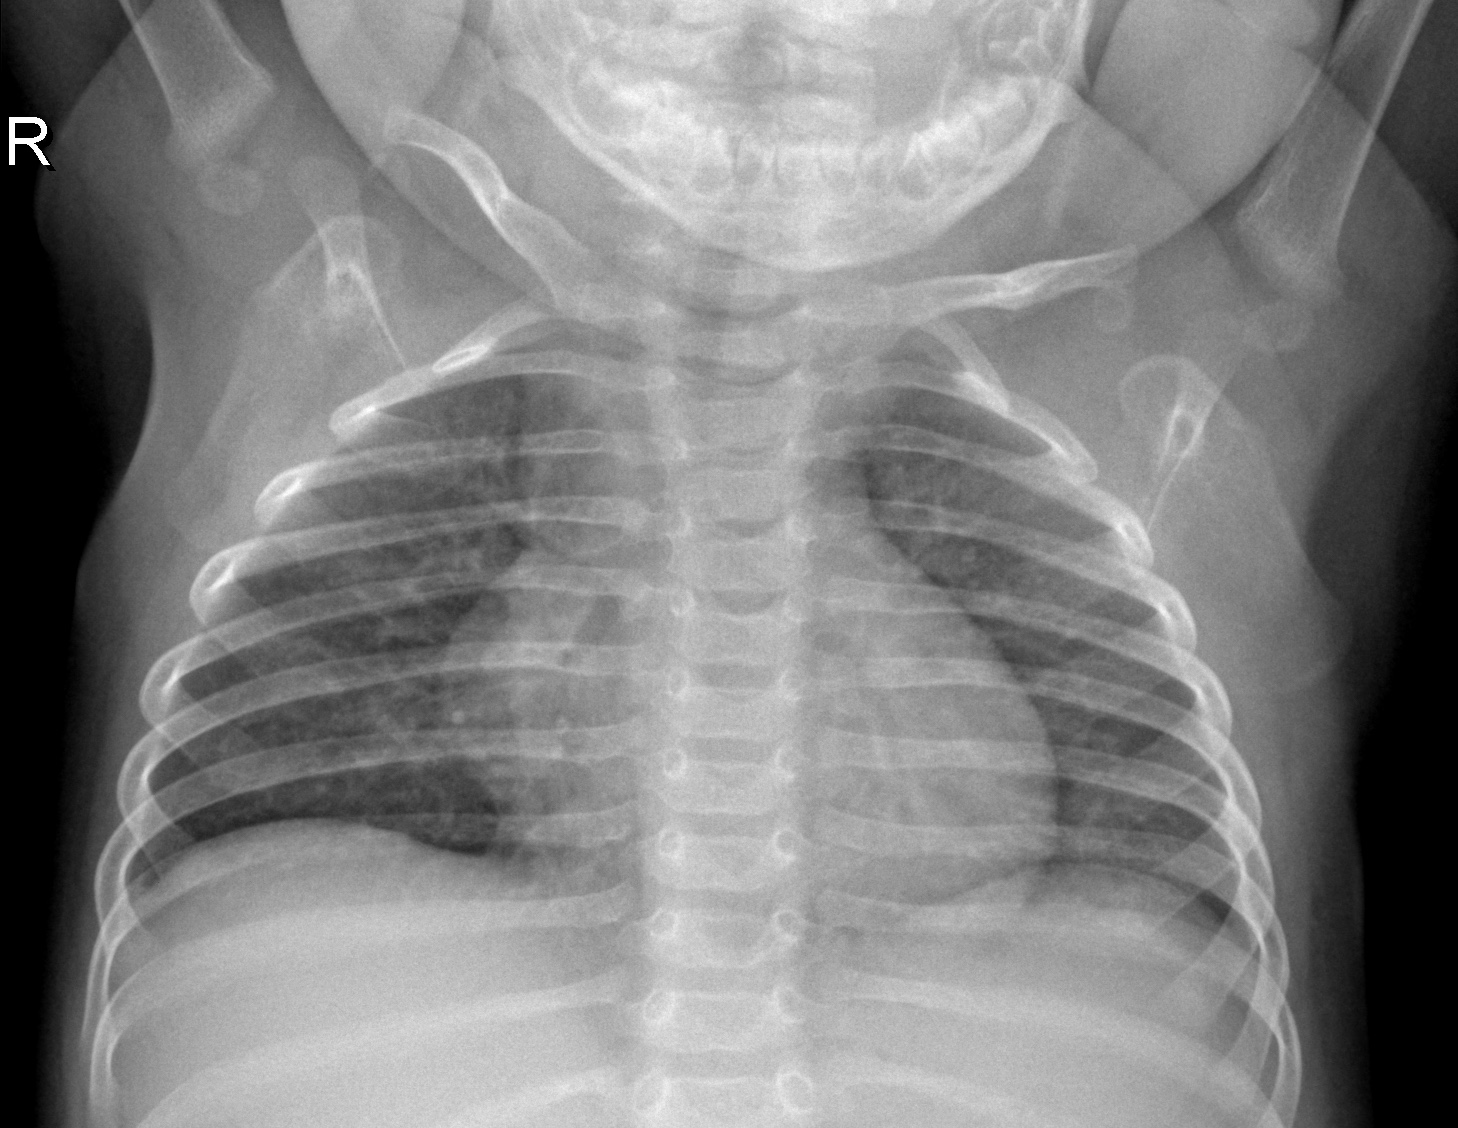

In [ ]:
NORMAL = list(data_dir.glob('NORMAL/*'))
Image.open(NORMAL[10])

And second, a PNEUMONIA positive image:

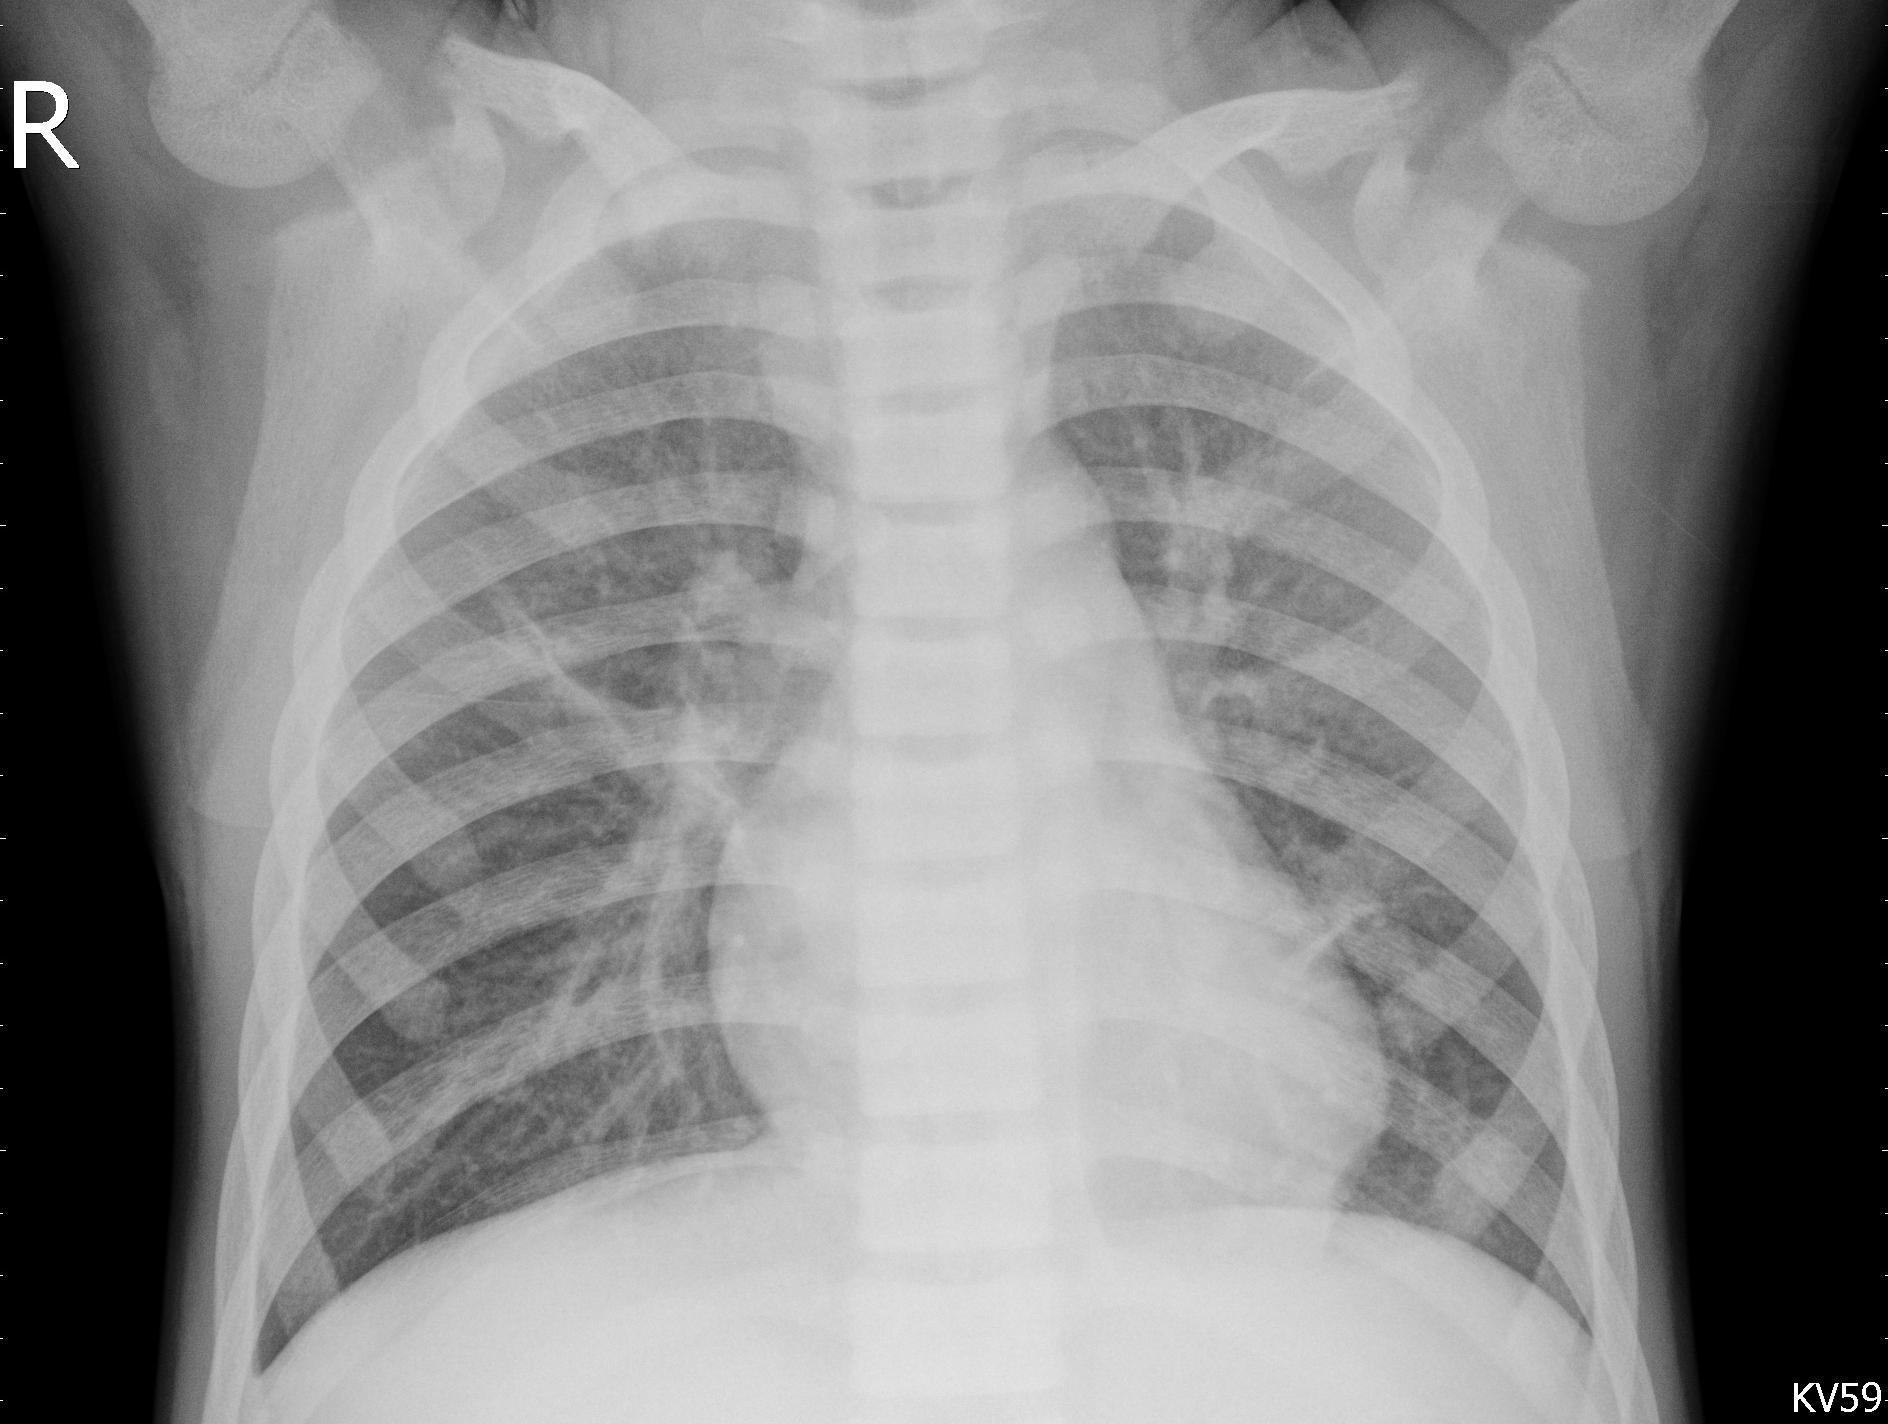

In [ ]:
PNEUMONIA = list(data_dir.glob('PNEUMONIA/*'))
Image.open(PNEUMONIA[199])

Great, the images are there. I'm no doctor, but the top one looks like a baby... (thankfully a healthy baby). I wonder the ages of the people behind these X-rays. It would be cool to combine these images with other medical data like symptoms of the patients to create a model with even more features. 

#### **Sizes**

For an image classification neural network, we need consistent shape and size of our inputs - this means image dimensions. After a quick glance at the image folders, it is obvious that all X-Rays are not a consistent size and dimension of pixels. Let's check how large and how small these images can be before we decide what size we would like to work with. 

In [ ]:
normal_sizes = []
for i in NORMAL:
  normal_sizes.append(Image.open(i).size)

print("For NORMAL class images")
print(f'min size: {min(normal_sizes)}')
print(f'max size: {max(normal_sizes)}')

For NORMAL class images
min size: (912, 672)
max size: (2916, 2583)


In [ ]:
pneu_sizes = []
for i in PNEUMONIA:
  pneu_sizes.append(Image.open(i).size)

print("For PNEUMONIA class images")
print(f'min size: {min(pneu_sizes)}')
print(f'max size: {max(pneu_sizes)}')

For PNEUMONIA class images
min size: (384, 127)
max size: (2772, 2098)


So, the dataset contains some fairly large images - much larger than we could process quickly for thousands of training images. Even the smallest image in the NORMAL class is faily large in terms of computation. The PNEUMONIA class contains slightly smaller images at times, the smallest being (384, 127). Resizing all the images down to this would lose us a lot of good information. Slightly sizing up these small images (keras will interpolate pixels) to a desired dimension is better. 256 by 256 pixels is a very common size used in image classification, and a power of 2, which can sometimes help models run smoother. Because we have fewer small images and many huge ones, I am going to elect to use a 512 x 512 image size. This image size and a 32 image batch size is about the highest my machine can process with it's given local memory. This is the next power of 2 after 256, so 512 adheres to our power of 2 'rule'. If this computation takes much too long, sizing down to 256 is easy, but we might as well try to include more information and resolution first. 512^2 with 32 images batches should take around 3 hours to process for 20-30 epochs and a few million trainable parameters. This is around the desired training time I want to hit to acheive a good model.

#### **1-Channel**

We also need to consider how many channels or layers we want the images to be for modeling. Most image files are automatically encoded into 3-channels (layers), red, green and blue (RGB). But for X-rays, we are only concerned with differences of brightness, not color. For this reason when the image information is loaded, it will be done in black and white (grayscale) so that there is only 1-channel. This will also speed up processing time,as each image now has 1/3 the amount of pixel as before but hasn't lost any of the information we are concered with. This will be done during the dataset creation step below. 

## **Data Preparation**

As we import and prepare this data for modeling, a few things need to be done.

- Split into training and validation sets.
- Resize images to same dimensions.
- Convert to 1-Channel grayscale.
- Put images into "batches".
- Scale each pixel element from 0-255 range to 0-1.

The data will be imported with a Keras utility function that conveniently provides us most of these parameters we can define right from the start. I will use 20% of the data for validation and 80% for modeling. We also tell this function the image dimensions we want all the images resized to, along with the batch size, color mode, and label mode. Here the label mode is set to binary as we only are predicting 2 classes. You will notice I do not scale each pixel value at this step. It is still part of the 'preparation' considerations, but is easier to include directly as a step in the sequential model.

In [ ]:
# Set batch and image sizes
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode = 'binary',
  color_mode = 'grayscale',
  subset = 'training',
  seed=888,
  image_size= (img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode = 'binary',
  color_mode = 'grayscale',
  subset="validation",
  seed=888,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5840 files belonging to 2 classes.
Using 4672 files for training.
Found 5840 files belonging to 2 classes.
Using 1168 files for validation.


Great, now that we have easily built the image datasets with Keras, lets check their shape before proceeding.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 1)
(32, 1)


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


The image_batches are shape (32, 512, 512, 1), as we want. 32 is the batch size, the number of images per batch. The images have been resized to 512 by 512 by 1-channel.

The labels_batch are the corresponding labels for the image batch. The shape is (32, 1), 32 images per batch and a 1-dimensional label. We also can see that the labels have been processed correctly: 'NORMAL' and 'PNEUMONIA'.

#### **Speeding up training**

The Tensorflow documentation lists a couple steps it suggests to speed up image training and memory usage. I comared a brief model with and without these settings, and speed was noticably improved with thei seggested settings. This includes calling .cache() on our training and validation sets to keep them in working memory. the ,.prefetch method increases speed by overlapping preprocessing and model execution. Thanks tensorflow docs!

In [ ]:
# Suggested configurations from Tensorflow documentation
# .cache() keeps images in memory from initial load
# .prefetch() overlaps preprocessing and model execution
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Modeling**

#### **Baseline**

Now it's time to build the model with Keras. This consists of decided what kind and how many hidden layers to include. There is a trade off between complexity and computation time, and more complex is never necessarily better. The plan for this anlysis is to begin with a baseline model that is simple and will process quickly. Then, introduce more layers and build a more complex second model and evaluate the performance/complexity/time trade-off.

Both models will begin with a Rescaling layer so that pixel values range from 0 to 1. And both models will end with a Dense layer with a single node and sigmoid activation function so that it can be turned on/off (1/0) and represent our binary classification output.

The hidden layers in the middle will vary between the two models. For the simple baseline, only a couple dense layers will be included. The dense layers follow a Flattening layer witch applies a transformation to our 512x512 images to convert them to a single dimension array of length 262,144. The number of nodes in the successive Dense layers will be powers of 2 and will decrease, focusing the information into fewer nodes and weights before the final single node output layer. The activation function used for these Dense layers will be 'relu' (Rectified Linear Unit) as it consistently performs best according to many different sources. 

In [ ]:
# Build the Baseline model

baseline = Sequential([
  # First I resize the images down for the simple model
  layers.Resizing(256, 256, input_shape=(img_height,img_width,1)),
  # Then the scaling layer
  layers.Rescaling(1./255),
  # Next flatten the images
  layers.Flatten(),
  # Now two Dense layers
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  # And the output layer
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,397,057
Trainable params: 8,397,057
Non-trainable params: 0
______________________________________________

We can see in the summary there are 8 million trainable parameters - this is quite a lot. It is easy to see here how  512 by 512 is a very large image when it comes to neural networks - this is why the number of trainable params is so high. If I had not scaled down, to 256, this number of trainable params for this model would have been 33.5 million. Interestingly, this can be reduced be first applying convolutional layers to the square image, which shrink it, before applying the flattening operation which essential outputs height times width number of parameters. This idea will be applied in the second model.

Next the model needs to be compiled with the loss functions and metrics we want to train on. The loss function for binary classifications is Binary Crossentropy and the optimizer I will use is 'adam' as it is suggested by the tensorflow documentation for the best performance. 

The metrics that the model performance will be scored on are important to consider. Naturally we want to train on overall accuracy of the model, but given this diagnostic problem, we also want to maximize the recall score, which minimizes False Negatives. We want to minimize these because it is the worst outcome contextually - to mis-diagnose a sick person as healthy. The Keras metric I will use isn't called 'recall', but instead just FalseNegatives.

Then, the model can be fit and trained. I have opted to train for 30 epochs based on the tests I have done. This means the model will see all of the images 30 times as it continues to train and backpropogate.

In [ ]:
baseline.compile(optimizer='adam',
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])

epochs=30
baseline_results = baseline.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
146/146 [==============================] - 54s 133ms/step - loss: 1.0463 - binary_accuracy: 0.8275 - false_negatives: 389.0000 - val_loss: 0.5699 - val_binary_accuracy: 0.8587 - val_false_negatives: 6.0000
Epoch 2/30
146/146 [==============================] - 11s 73ms/step - loss: 0.4788 - binary_accuracy: 0.8808 - false_negatives: 269.0000 - val_loss: 0.3993 - val_binary_accuracy: 0.9110 - val_false_negatives: 12.0000
Epoch 3/30
146/146 [==============================] - 11s 72ms/step - loss: 0.3694 - binary_accuracy: 0.9024 - false_negatives: 213.0000 - val_loss: 0.1809 - val_binary_accuracy: 0.9366 - val_false_negatives: 42.0000
Epoch 4/30
146/146 [==============================] - 11s 73ms/step - loss: 0.1989 - binary_accuracy: 0.9309 - false_negatives: 146.0000 - val_loss: 0.1672 - val_binary_accuracy: 0.9452 - val_false_negatives: 20.0000
Epoch 5/30
146/146 [==============================] - 11s 73ms/step - loss: 0.2475 - binary_accuracy: 0.9103 - false_negatives: 203.

Once it got started, this model ran fairly quickly given the number of parameters - about 15 minutes.

Below, I add code to save or load the model into memory. This is so that we dont have to re-run the model to access and evaluate the results and history. (Note: file paths point to my local Google Drive where this was run, not to files in this github repository, and need to be updated if this repo is forked)

In [ ]:
# Save model
baseline.save('/content/gdrive/MyDrive/xray_cnn/models/baseline')

# Load model
# baseline = keras.models.load_model('/content/gdrive/MyDrive/xray_cnn/models/baseline')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/xray_cnn/models/baseline/assets


#### **CNN Model**

This next model will be a bit more sophisticated as it will utilize convolutional layers. An image convolution looks at a not just each pixel, but the pixels surrounding it as well. For Keras Conv2D, we want to specify a few things. The first parameter is the dimensionality of the output, eg. the number of filters/layers in the convolution. The second parameter is the kernel size, this tells the convolution how near the current pixel to consider. 1 here implies a 1x1 convolution kernel that just looks at each neighbor for that pixel. A 2 here implies a 2x2 kernel and that the nearest 2 pixels in each direction from the current pixel are looked at. Padding refers to how the convolution deals with edge values, here 'same' means it makes them all the same (zero). And finally we use the same 'relu' activation function for these layers.

The next new kind of layer we use is MaxPooling. This layer downsizes the image shape by taking the maximum value accross each 'pool'. Here I use the preset parameter of a (2,2) pool. These MaxPooling layers really help to reduce the number of parameters in the end model, so we apply one after each Convolutional layer. Pooling layers also act like dropout layers in that the can reduce overfitting.

Notice that different numbers of filters and kernel sizes are used in each Conv2D layer. This is so that we can examine the image on different spacial scales in each layer, searching for different sized features in the images that may be picked up on differently.

Finally, the image is flattened and fed into two Dense layers, and then the final binary output layer.

Note here that the large 512x512 image size has been retained. This is because our pooling layers decrease the number of parameters, so we can afford to feed in a few more parameters (pixels) up front. Having more resolution here will also help the performance of the convolutions.

In [ ]:
# Build the model

cnn_model = Sequential([
  # First a preprocessing layer to scale from 0 to 1
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  # Next a set of convolutional and pooling layers
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Then flatten for the dense hidden layers
  layers.Flatten(),
  # Now two dense layers decreasing in size, activation still relu
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  # Final layer with a single node and sigmoid activation for binary 0, 1
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 16)      32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)       

Then the model is compiled with the same loss function and scoring metrics as before.

In [ ]:
cnn_model.compile(optimizer='adam',
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])

For this second model, I am going to add a Callback class. This will enable us to extract prediction information for each epoch in the form of a confusion matrix and ROC curve. The code below defines this class, and at the bottom we instatiate it for the current model.

In [ ]:
from keras.callbacks import Callback
from scikitplot.metrics import plot_confusion_matrix
#from sklearn.metrics import precision_recall_curve

class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.empty((32, 1))
        y_true = np.empty((32, 1))

        for batch, labels in self.validation_data:
          y_pred = np.concatenate([y_pred, (self.model.predict(batch))])
          y_true = np.concatenate([y_true, labels])
                 
        y_pred_class = np.around(y_pred)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, np.around(y_pred), ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save precision recall curve
        # fig, ax = plt.subplots(figsize=(16,12))
        # fig = precision_recall_curve(y_true, y_pred)
        # fig.savefig(os.path.join(self.image_dir, f'pr_curve_epoch_{epoch}'))

# Now instantiate for our CNN model
performance_cbk = PerformanceVisualizationCallback(
                      model = cnn_model,
                      validation_data = val_ds,
                      image_dir = 'cnn_performance_visualizations')

Now that the performance callback has been created, it can be added in the fitting stage of the model by specifying the 'callback' parameter.

Epoch 1/30
146/146 [==============================] - 506s 3s/step - loss: 0.2871 - binary_accuracy: 0.8778 - false_negatives_1: 209.0000 - val_loss: 0.1134 - val_binary_accuracy: 0.9563 - val_false_negatives_1: 30.0000
Epoch 2/30
146/146 [==============================] - 503s 3s/step - loss: 0.1341 - binary_accuracy: 0.9525 - false_negatives_1: 105.0000 - val_loss: 0.1125 - val_binary_accuracy: 0.9606 - val_false_negatives_1: 15.0000
Epoch 3/30
146/146 [==============================] - 506s 3s/step - loss: 0.1153 - binary_accuracy: 0.9585 - false_negatives_1: 90.0000 - val_loss: 0.1033 - val_binary_accuracy: 0.9632 - val_false_negatives_1: 13.0000
Epoch 4/30
146/146 [==============================] - 506s 3s/step - loss: 0.0959 - binary_accuracy: 0.9651 - false_negatives_1: 70.0000 - val_loss: 0.0883 - val_binary_accuracy: 0.9675 - val_false_negatives_1: 15.0000
Epoch 5/30
146/146 [==============================] - 507s 3s/step - loss: 0.0820 - binary_accuracy: 0.9688 - false_negati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch 22/30
146/146 [==============================] - 507s 3s/step - loss: 8.8708e-06 - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - val_loss: 0.3203 - val_binary_accuracy: 0.9632 - val_false_negatives_1: 20.0000
Epoch 23/30
146/146 [==============================] - 504s 3s/step - loss: 6.9582e-06 - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - val_loss: 0.3278 - val_binary_accuracy: 0.9632 - val_false_negatives_1: 20.0000
Epoch 24/30
146/146 [==============================] - 505s 3s/step - loss: 5.6535e-06 - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - val_loss: 0.3337 - val_binary_accuracy: 0.9632 - val_false_negatives_1: 20.0000
Epoch 25/30
146/146 [==============================] - 507s 3s/step - loss: 4.6569e-06 - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - val_loss: 0.3408 - val_binary_accuracy: 0.9632 - val_false_negatives_1: 20.0000
Epoch 26/30
146/146 [==============================] - 508s 3s/step - loss: 3.9237e-06 - bin

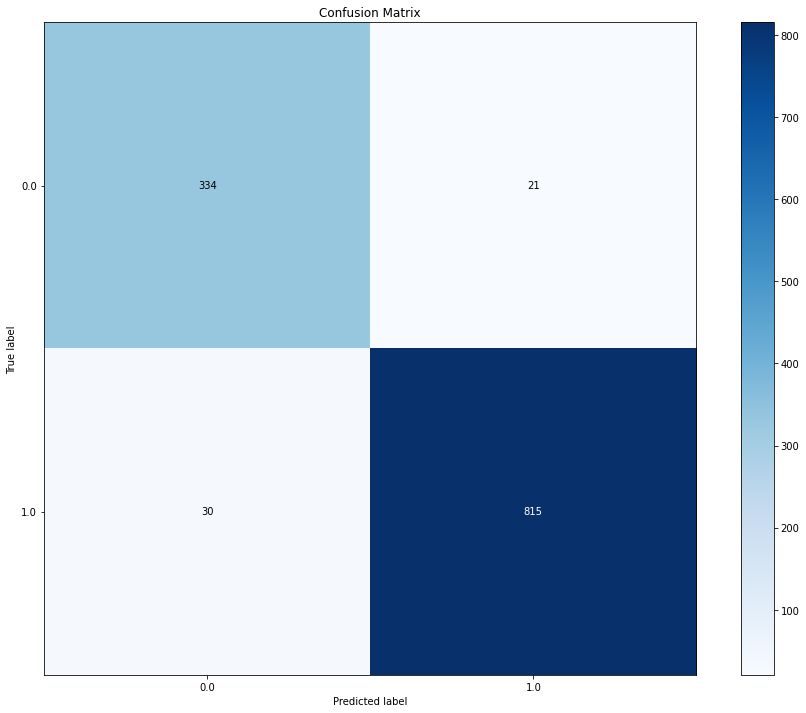

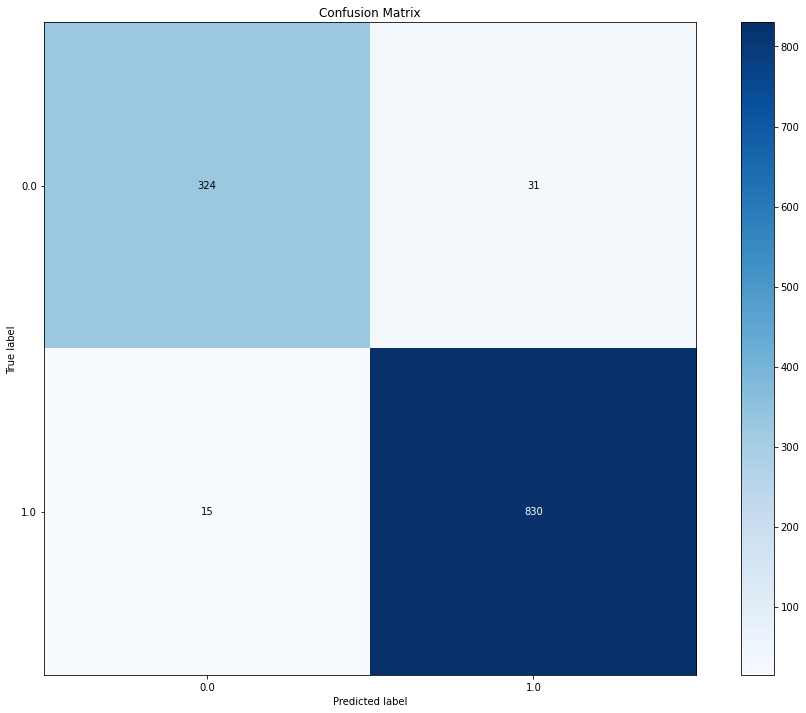

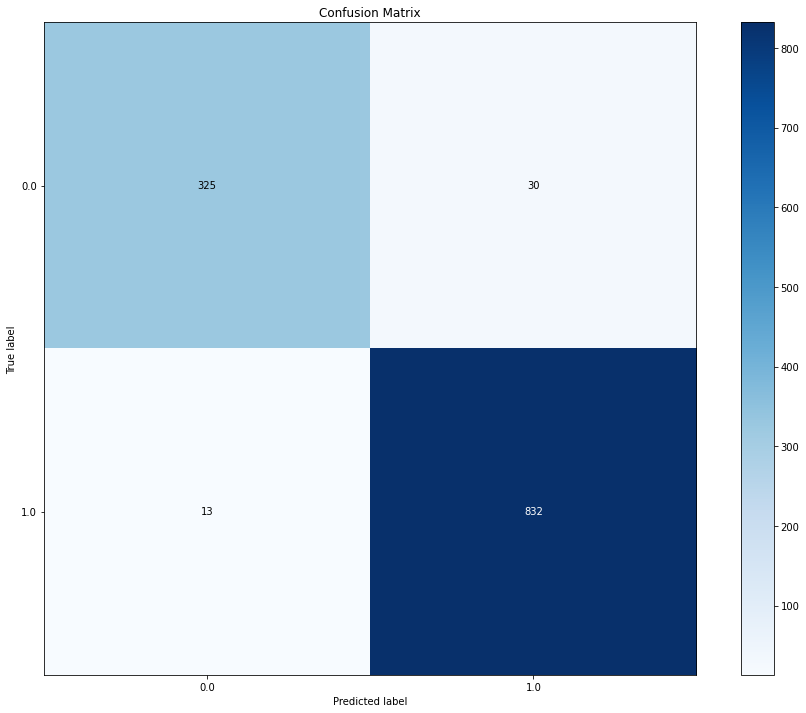

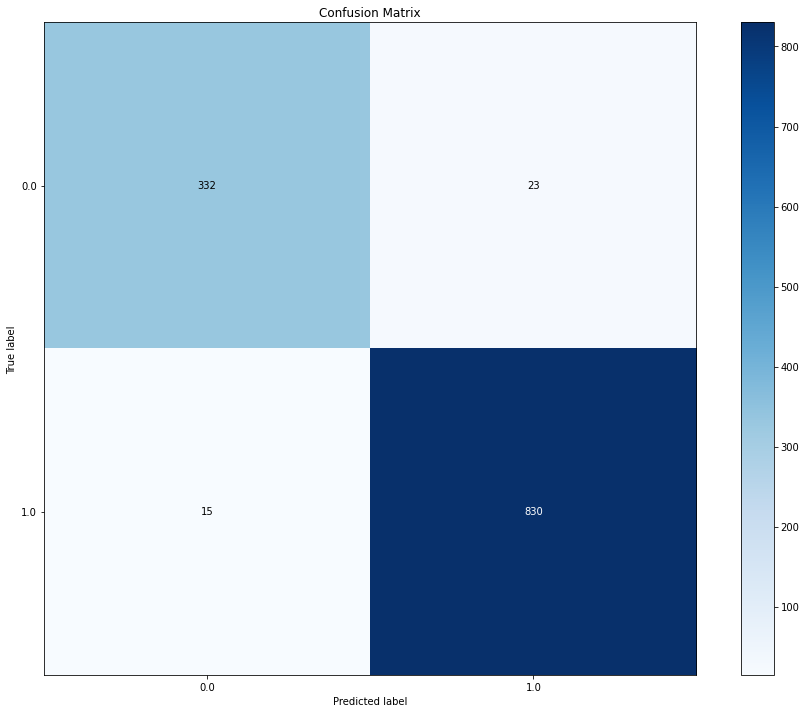

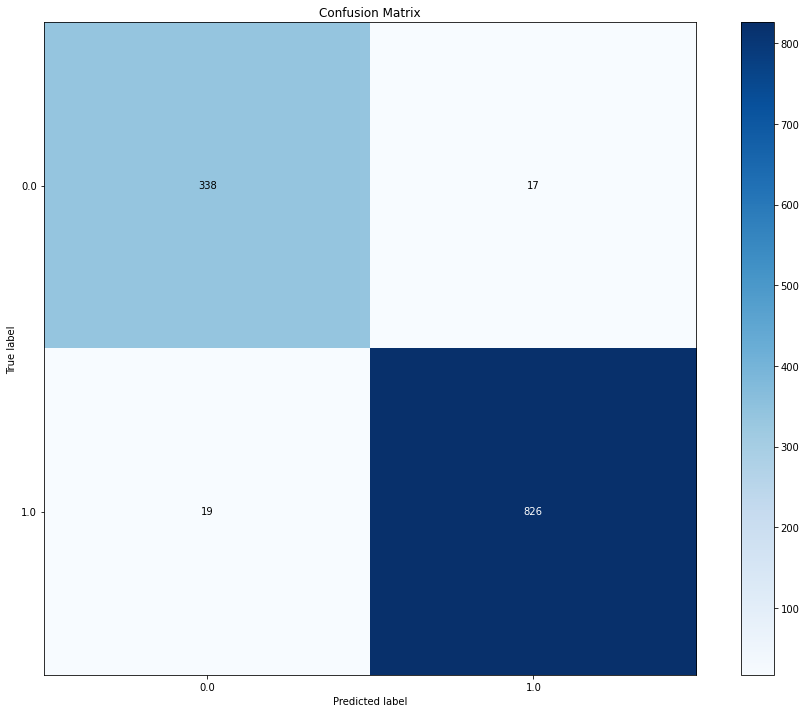

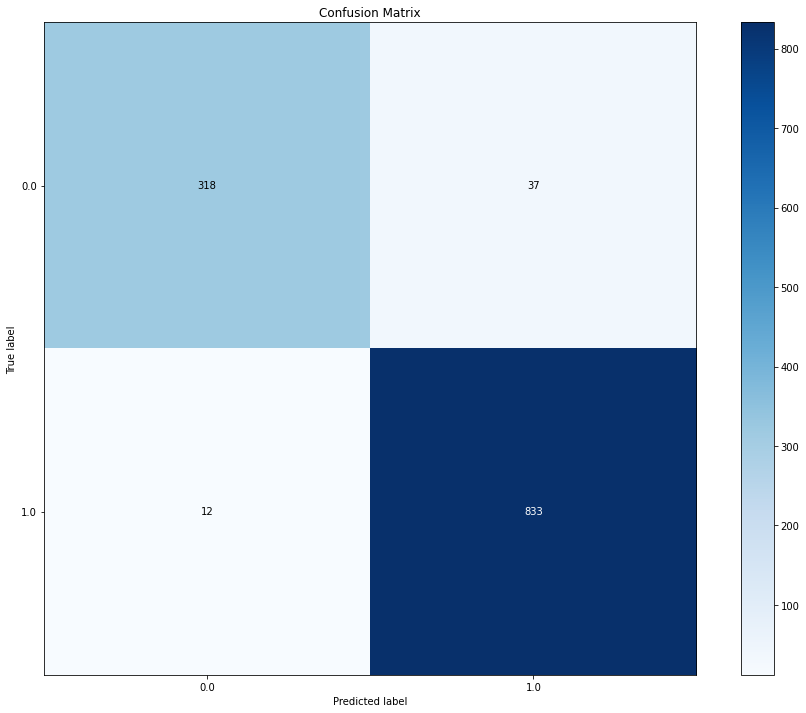

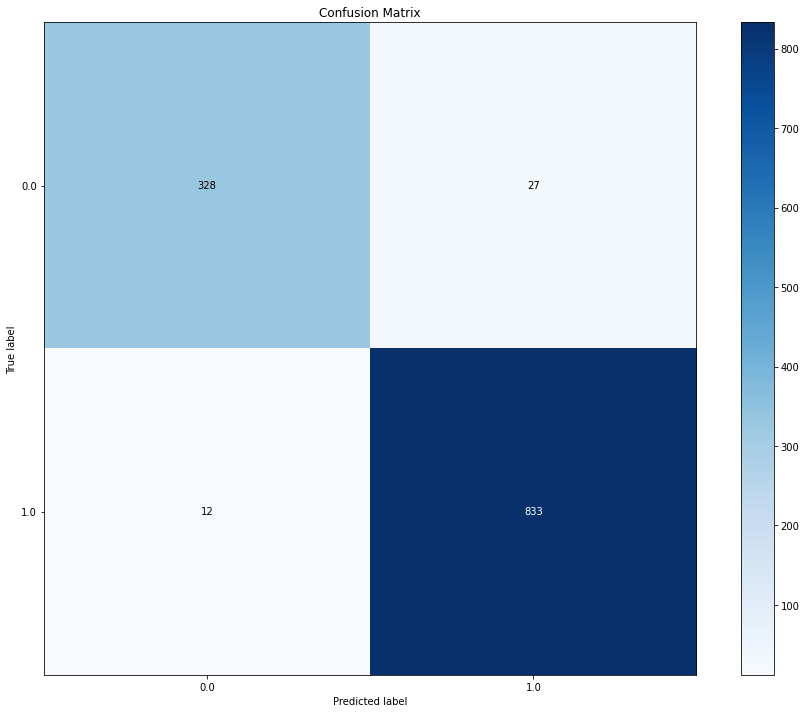

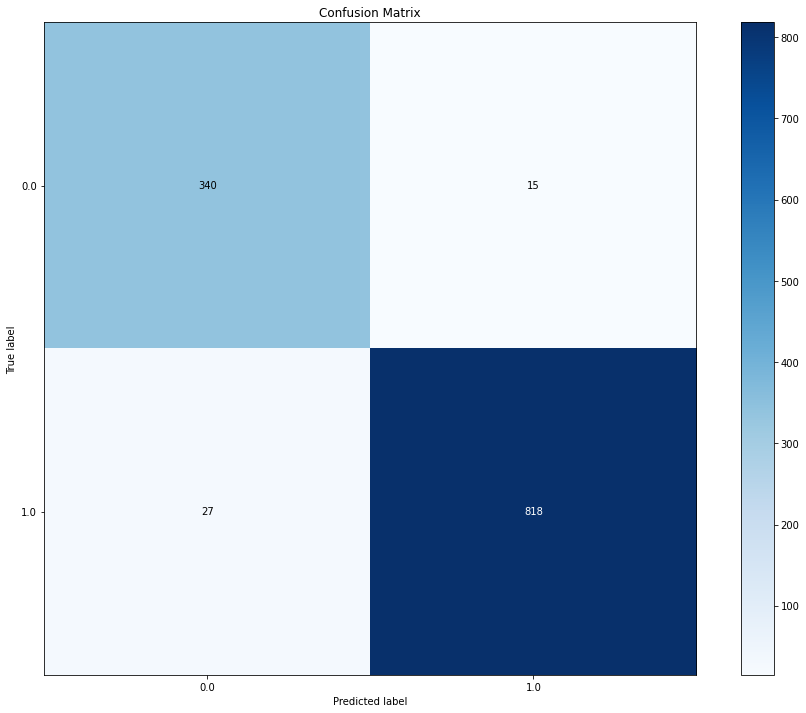

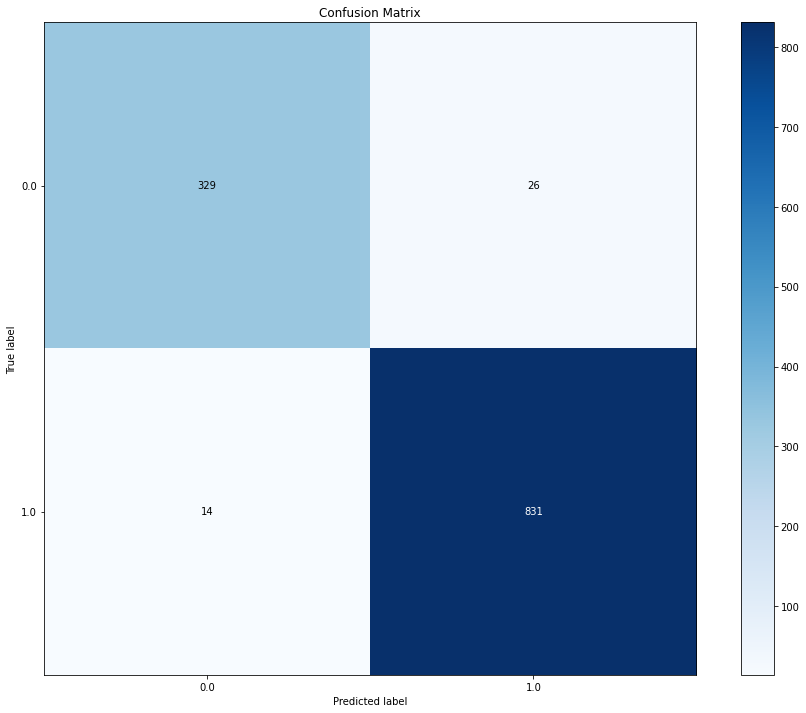

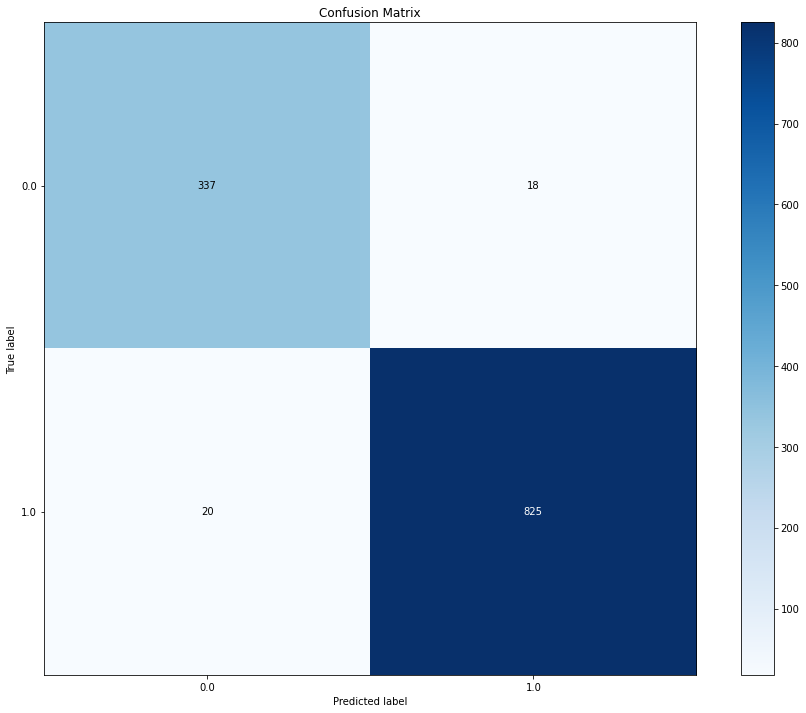

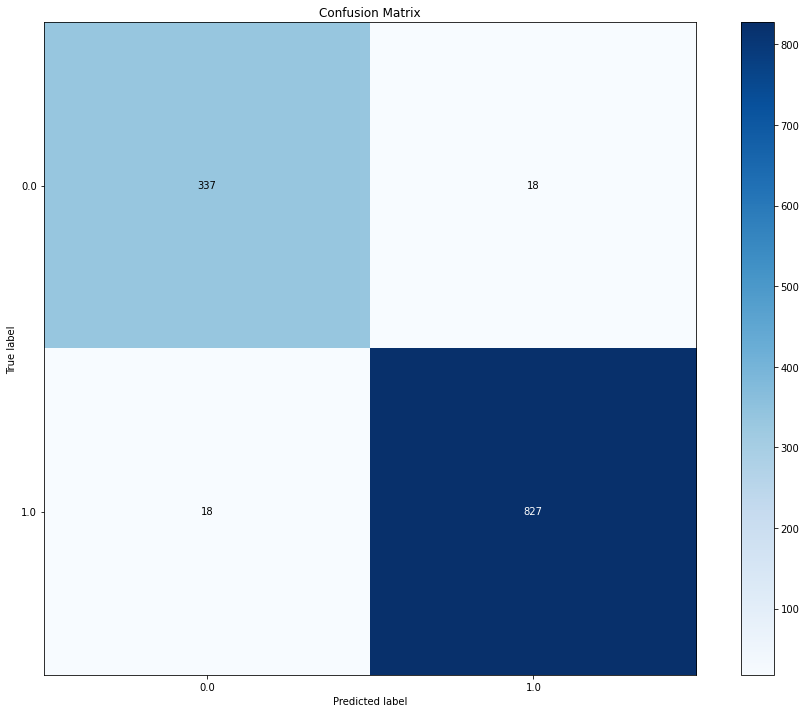

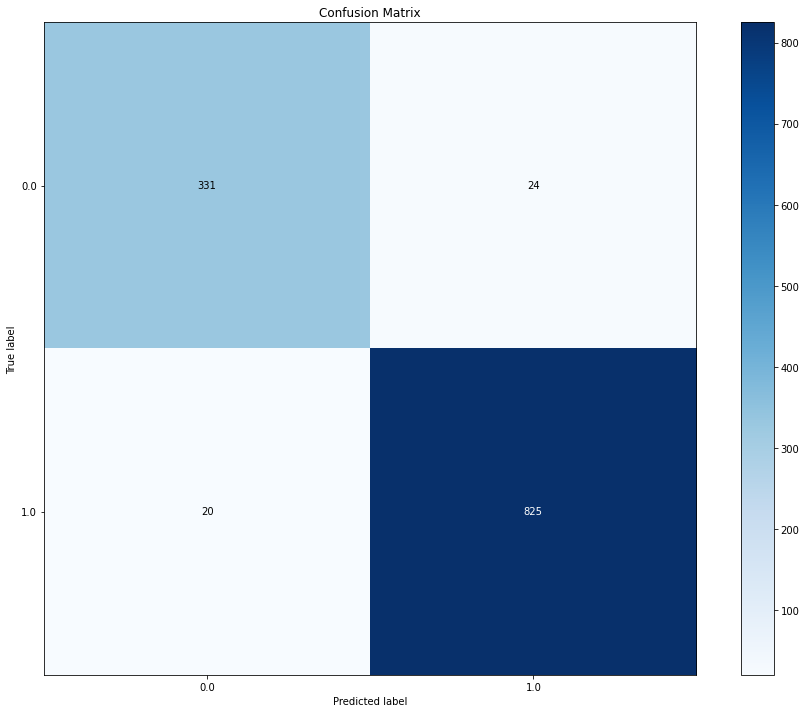

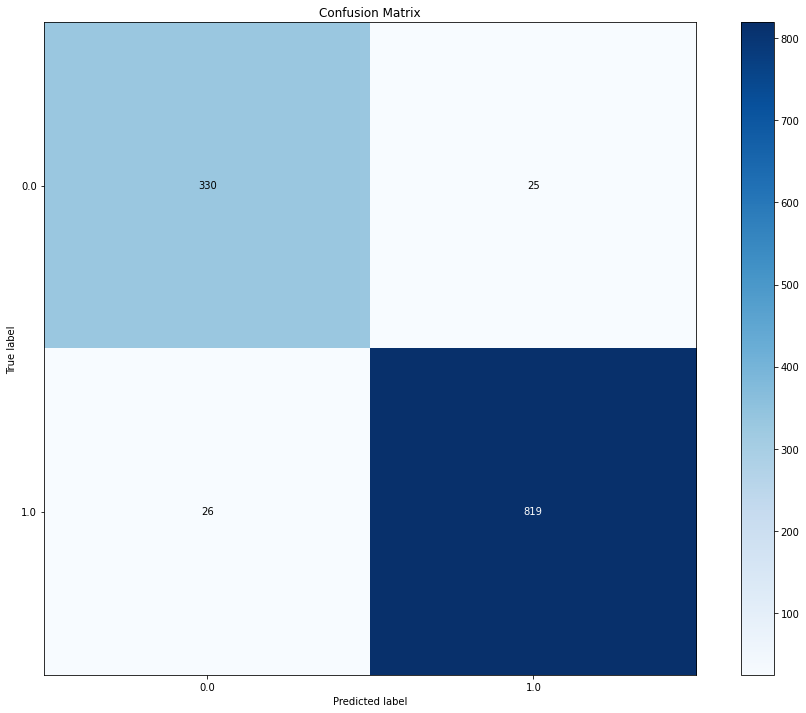

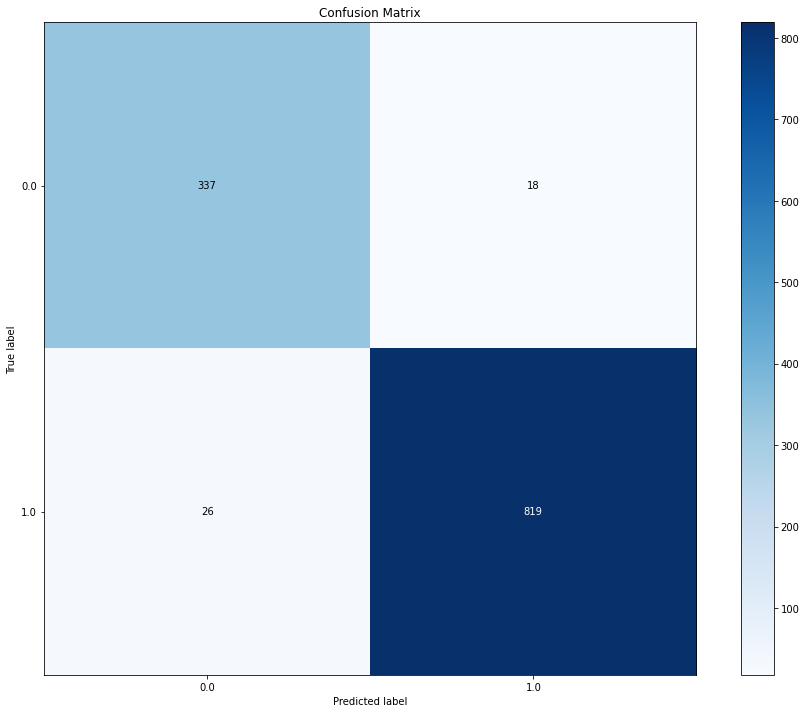

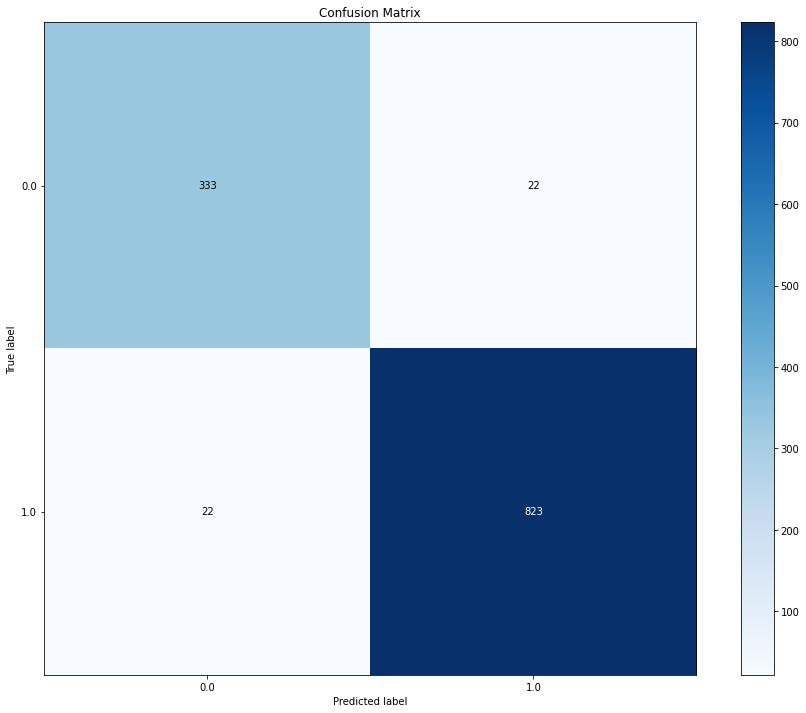

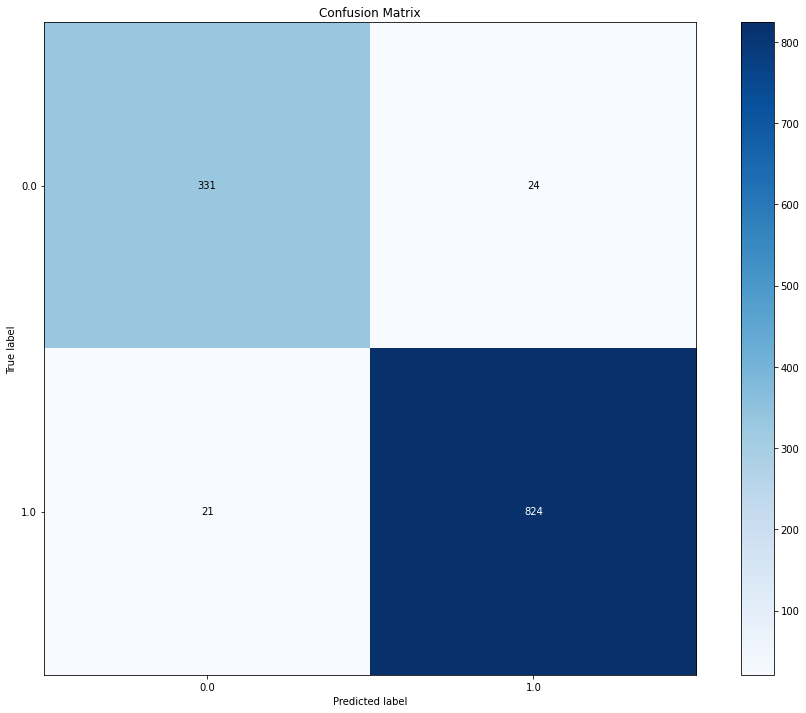

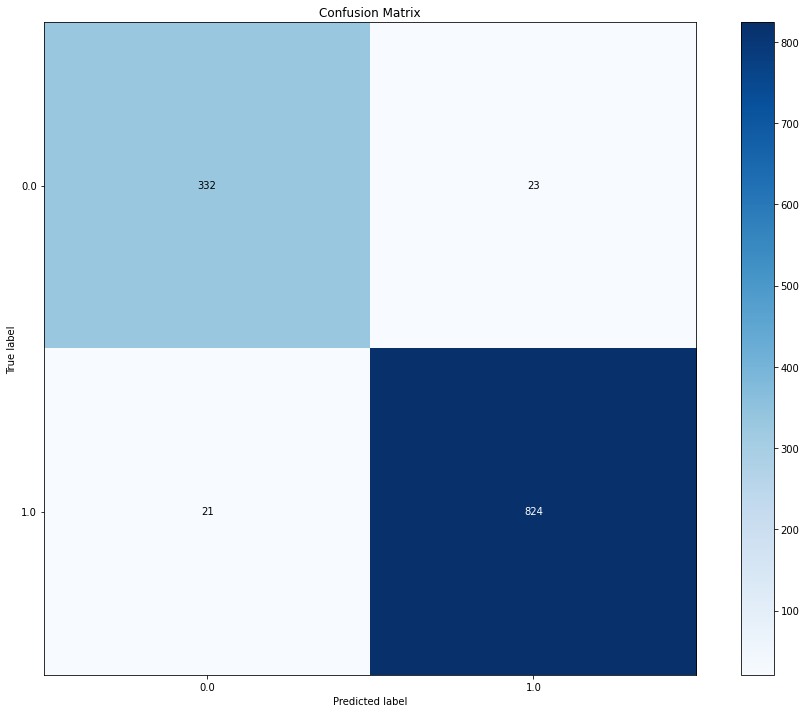

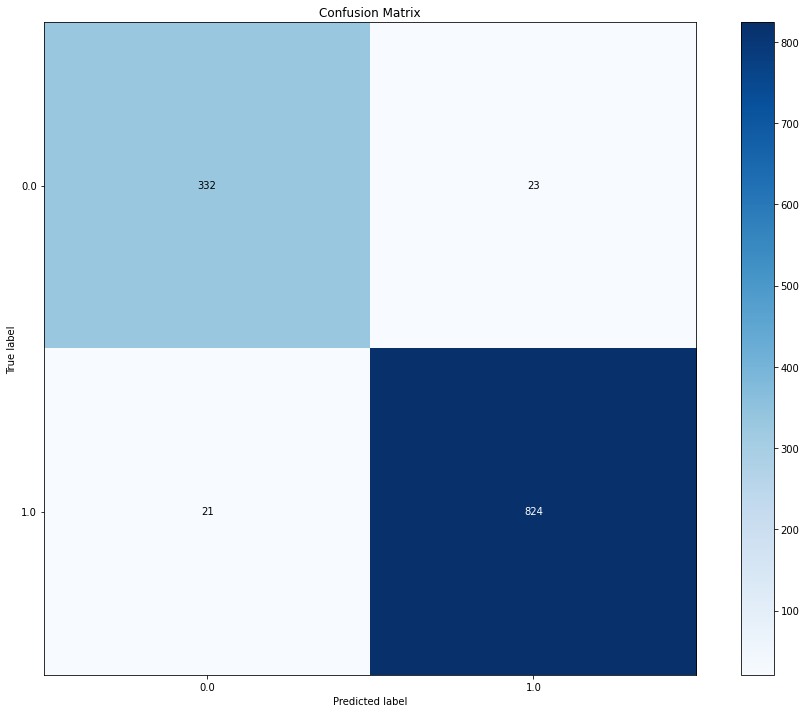

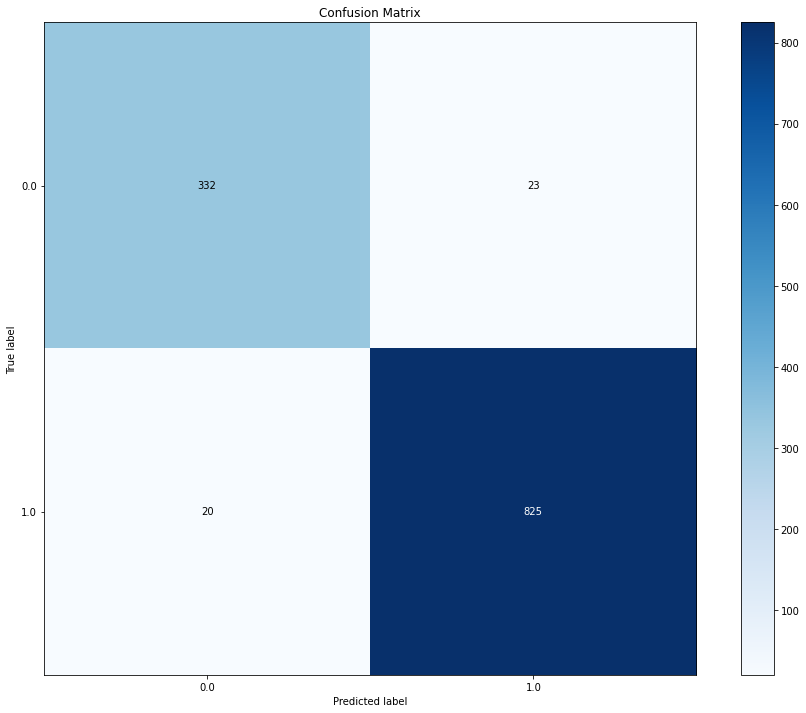

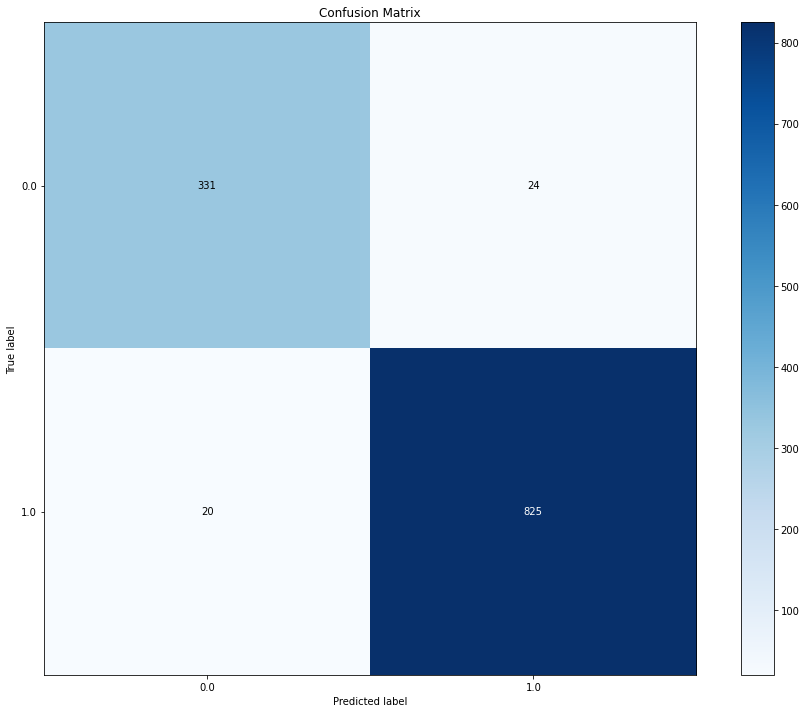

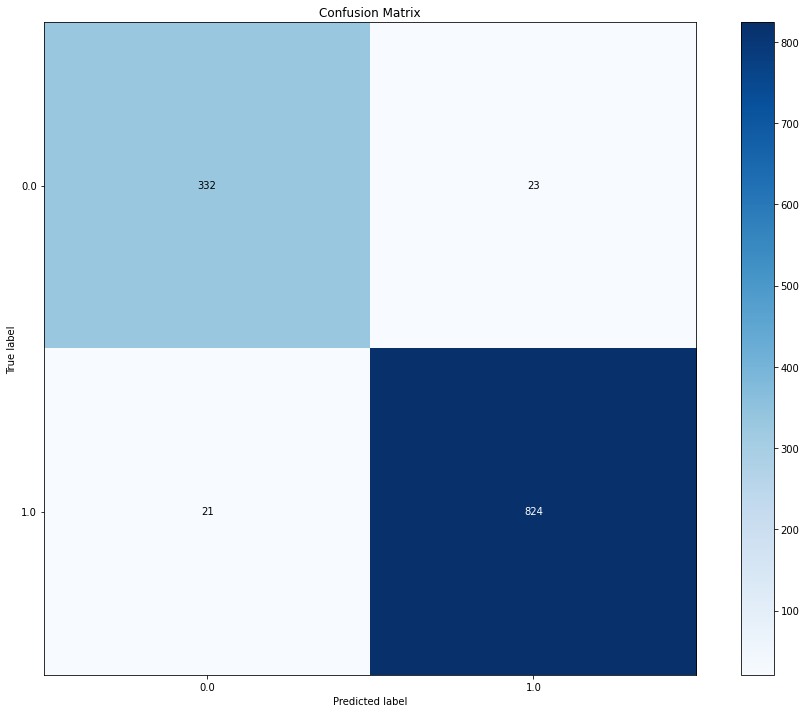

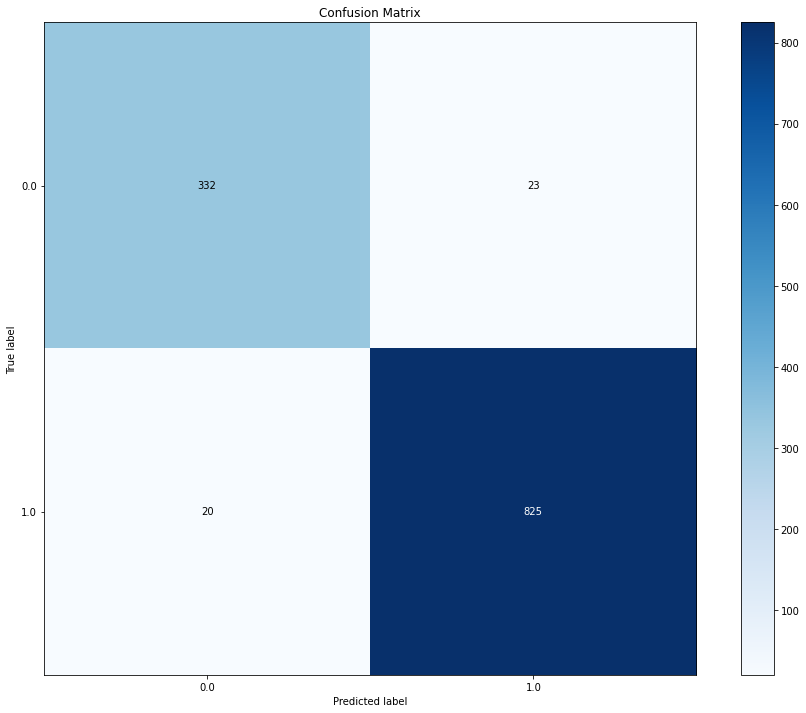

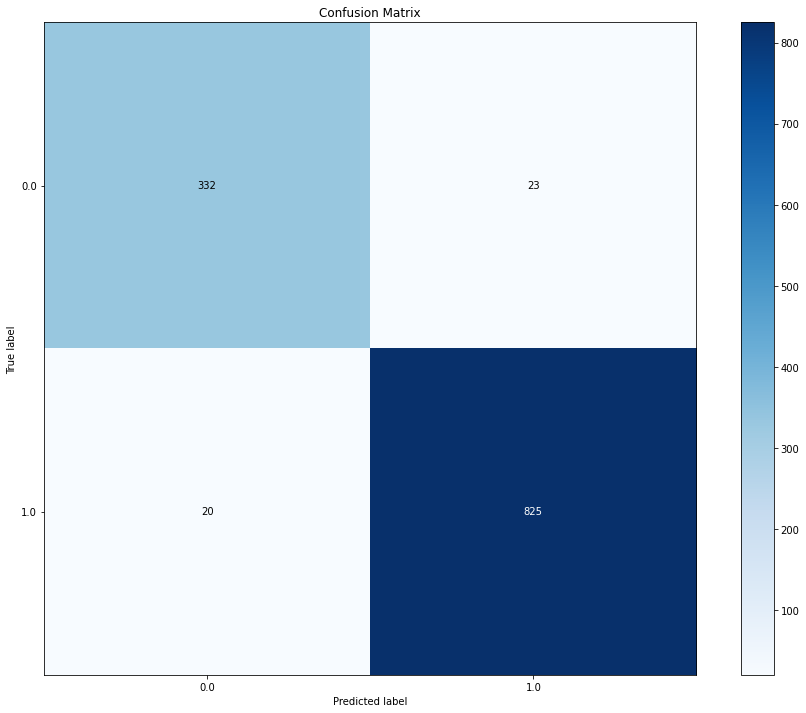

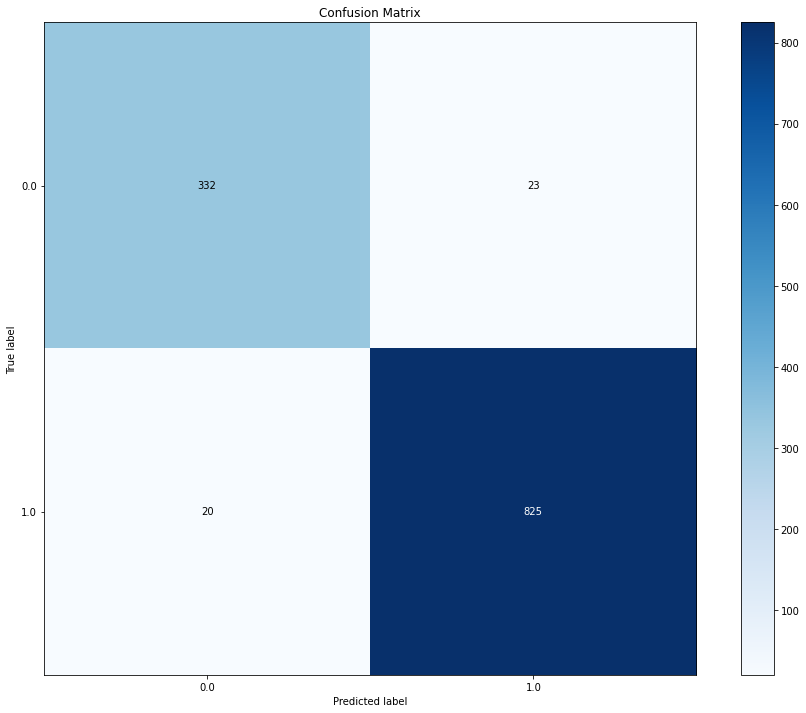

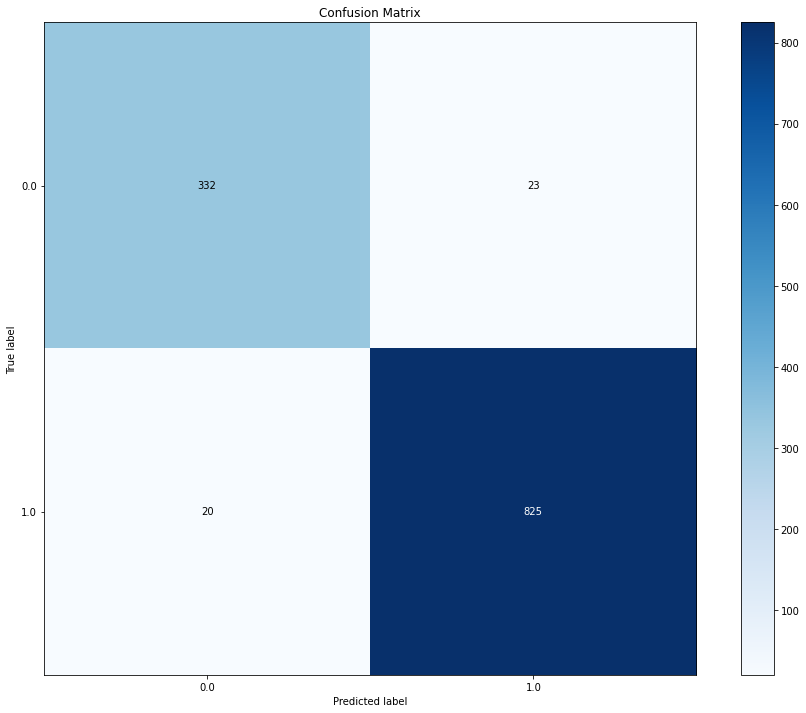

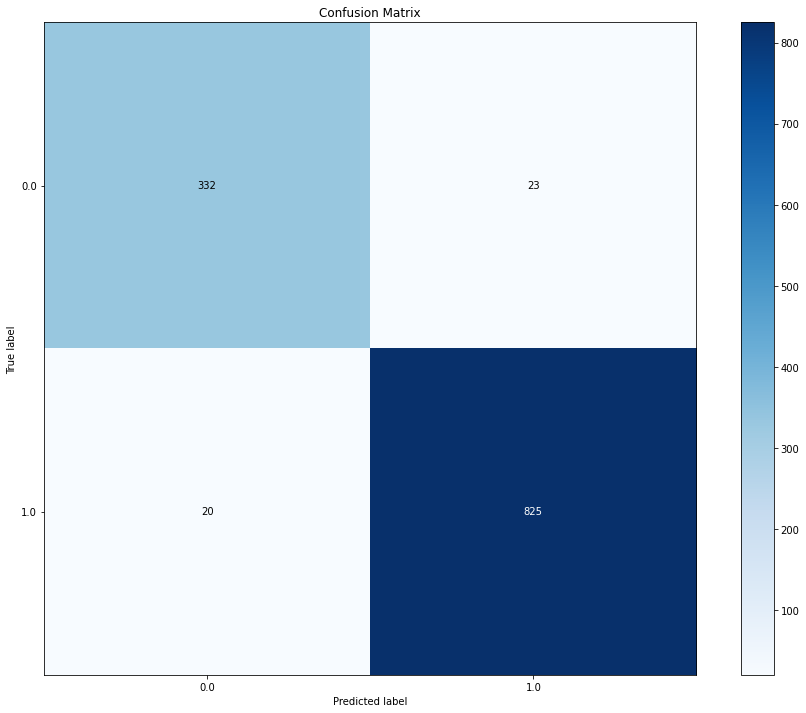

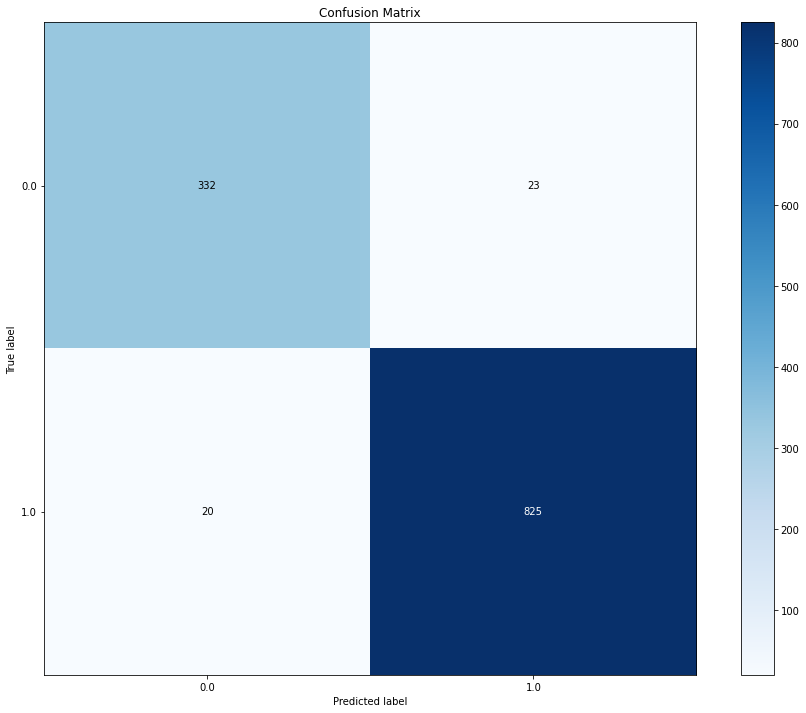

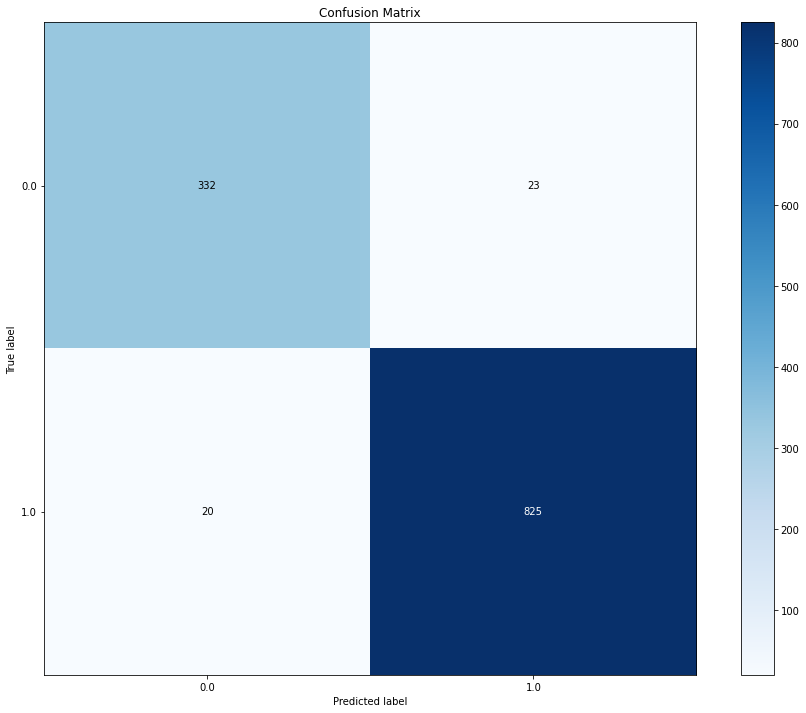

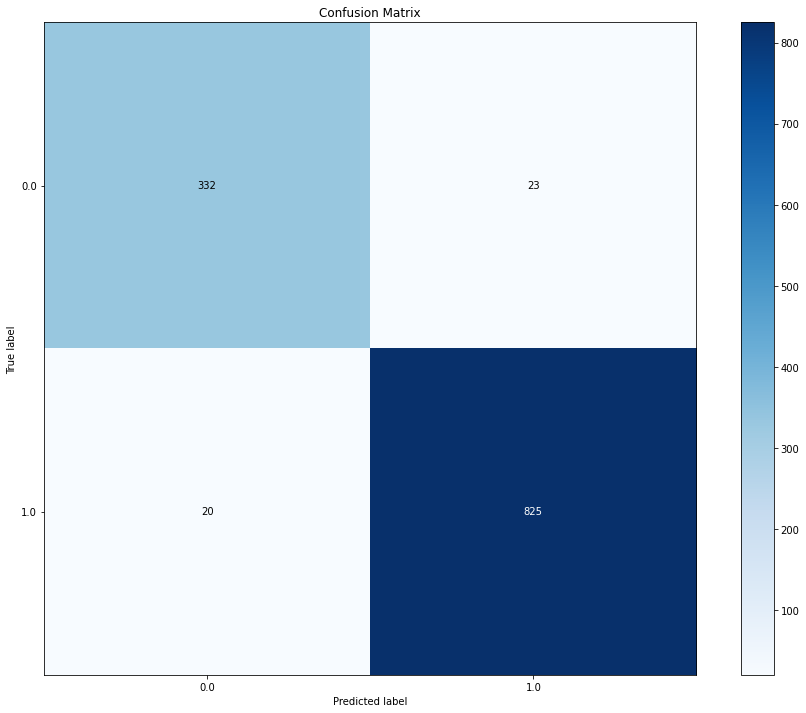

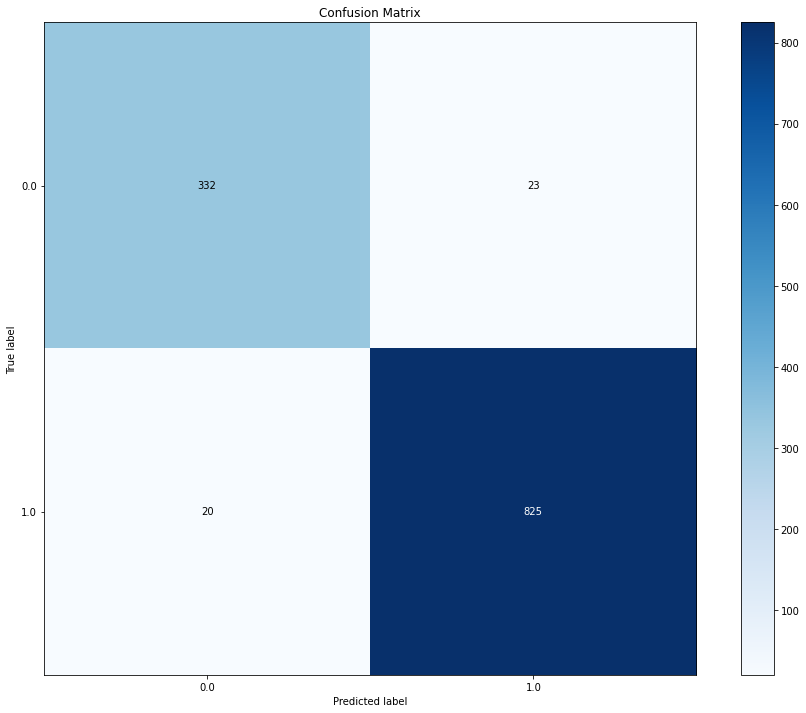

In [ ]:
epochs=30
results = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[performance_cbk]
)

Apologies for the scrolling and verbose output.....

In [ ]:
# Save model
cnn_model.save('/content/gdrive/MyDrive/xray_cnn/models/cnn_model')

# Load model
# cnn_model = keras.models.load_model('/content/gdrive/MyDrive/xray_cnn/models/cnn_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/xray_cnn/models/cnn_model/assets


Note that the pathways for saving files will be incorrect for the GitHub repository; they represent the structure of the Google Drive and Colab Environment this notebook was first run in.

## **Evaluation**

### **Baseline Model**

From a quick look at the fitting output, we can see that the baseline model did really well - around 93-95% accurate for the later epochs.

It is easier to evaluate these scores visually as the model evolves between epochs. Below I plot epoch vs loss, accuracy, and false negatives to see how the performance of the model changed as it saw the data more and more times.

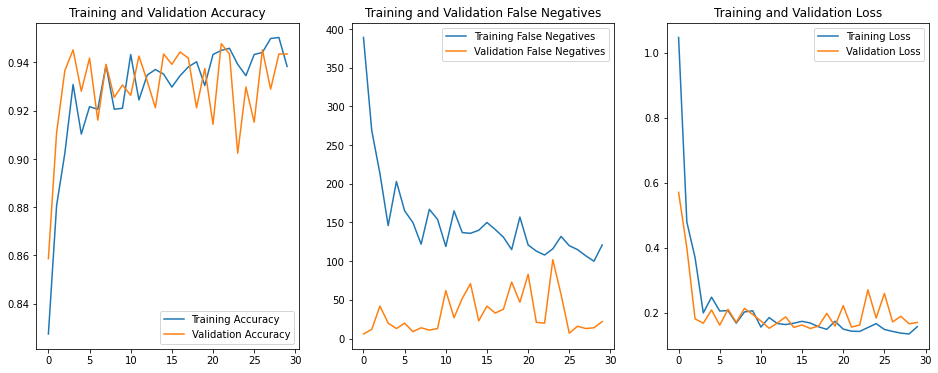

In [ ]:
acc = baseline_results.history['binary_accuracy']
val_acc = baseline_results.history['val_binary_accuracy']

loss = baseline_results.history['loss']
val_loss = baseline_results.history['val_loss']

fn = baseline_results.history['false_negatives']
val_fn = baseline_results.history['val_false_negatives']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, fn, label='Training False Negatives')
plt.plot(epochs_range, val_fn, label='Validation False Negatives')
plt.legend(loc='upper right')
plt.title('Training and Validation False Negatives')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

This baseline model got decent scores, but given the amount of noise we can still see towards the later epochs, it did not converge extremely well. Accuracy and loss bounced around a lot from epochs 20 to 27. Note that the disparity between training and validation false negatives is due to the different sizes of each set. 

Looking back up at the fitting/training output, if I had to choose an epoch from this model to test/deploy, it would be after epoch 29, the second to last. It is passed the noise we can see in the above accuracy and loss plots; the accuracy for training and validation are similar, 95% and 94% respectively; and both have relatively low numbers of false negatives given the rest of the model history.

### **CNN Model**

The Convolutional Network model had good scores right from the start of training - unfortunately a sign that it was quick to overfit and might not have properly expored many patterns in the data, just quickly found a few that did well. 97% accurate is still a good sign a CNN model is the way to go, but sampling patterns tell us we could improve training.

Let's examine the same progress of accuracy, loss, and false negatives through the training epochs as we did above. 

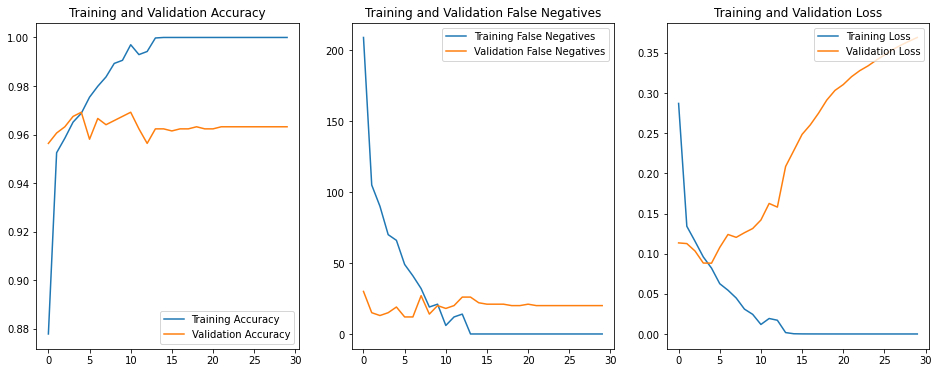

In [ ]:
acc = results.history['binary_accuracy']
val_acc = results.history['val_binary_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

fn = results.history['false_negatives_1']
val_fn = results.history['val_false_negatives_1']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, fn, label='Training False Negatives')
plt.plot(epochs_range, val_fn, label='Validation False Negatives')
plt.legend(loc='upper right')
plt.title('Training and Validation False Negatives')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

We can immedaitely see that for the validation dataset, the model did not really "learn" as training progressed. The final accuracy and number of false negatives is the same as the very beginning of training, and the validation loss got consistently worse the more we trained the model. An increase in loss means that even if our accuracy stayed the same, our model became less and less 'confident' in its predictions. 

Below let's compare a confusion matrix for an early epoch and a later one.

<img src='images/epoch_5_26.png'>

The 'best' model was actually very early in training. Epoch 5 had even lower false negatives and false positives than what the model settled on in later epochs. 

### **Conclusions**

**While a 97% training accuracy score sounds good, I do not think we should assume this to be a successful model yet.** Many patterns in the training suggest it is overfit to training and did not 'learn' patterns reflected in validation data

Here are the reasons I would retrain the model:
  - Validation accuracy and number of FNs stayed fairly consistent through training. But while 96% accurate is good, not seeing any development through the models training epochs suggests that even though we have constructed a successful model, it didn't "learn" much from the data.
  - After only a few epochs, the model began to overfit the training data and get scores of 100%. Validation scores did not improve at all throughout training. 
  - Finally, another reason to suspect we have over-fit and over-trained this model is the increase in validatation loss as we go through more epochs. The accuracy stays the same, which means this increase in loss is a result of less certain of predictions (probabilities) of validation samples even if it is getting the same number correct. 
  - One more thing to note is that the number of False Negatives stayed the same for the second have of training (20). While it is possible these are different samples, I suspect that the model is missing the same 20 each time. Whether it is possible to properly evaluate these images is something to quesiton, along with the possibility that a local minimum in False Negatives and accuracy was found, preventing the model from learning the context to properly classify these 20 outlier samples. 


Here are a few things I would start with when re-training to reduce overfitting:
  - Add Dropout layers to regularize training. These make the model 'forget' the values of nodes at a certain rate so they are trained again.
  - Reduce the complexity of the model by reducing the number of overall parameters. This could look like removing one or two of the 3 convolutional layers. 
  - Increase the size of the dataset by including reflected images. In doing this we would certainly reduce the image dimensions so that training does not take absurdly long.
  - Try regularization techniques like Weight and Activity reglurization, which penalizes the model for too high of weight and activiation values. It is also possible to directly constrain the weight values for the model if we wished. 
  - Test different batch sizes. Smaller batches backpropogate training information more frequently than larger batches (eg. the model always knows the direction of gradient descent for smalled batches). Tweaking this may help training, but I suspect it is not the main root of our overfitting problem.

There are always ways to improve!

------------------------------------------------

**Thanks for reading!**

##### Sources:
[The dataset on Mendelay](https://data.mendeley.com/datasets/rscbjbr9sj/3)

[Tensorflow Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)

[Keras Documentation](https://keras.io/api/)